## Import Libraries

In [1]:
!pip install medmnist


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

import medmnist
from medmnist import INFO, Evaluator

## Parameters

In [3]:
batch_size = 128
num_epoches = 3
lr = 0.001

info = INFO['pathmnist']
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## Data Processing and Load

In [4]:
# Load data
#path = '../Dataset/pneumoniamnist.npz'
#data = np.load(path)

#Split data
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)
pil_dataset = DataClass(split='train', download=True)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*batch_size, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*batch_size, shuffle=False)

Using downloaded and verified file: C:\Users\henrr\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\henrr\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\henrr\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\henrr\.medmnist\pathmnist.npz


In [5]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: C:\Users\henrr\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K i

## ResNet-18 construction

In [6]:
# ResNet-18
class ResidualBlock(nn.Module):
    expansion = 1
    
    def __init__(self, inCh, outCh, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channels=inCh, out_channels=outCh, 
                            kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(outCh),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=outCh, out_channels=outCh, 
                            kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(outCh)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or inCh != outCh:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=inCh, out_channels=outCh, 
                            kernel_size=1, stride=stride),
                nn.BatchNorm2d(outCh)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, classes=9):
        super(ResNet18, self).__init__()
        self.classes = classes
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer_1 = self.make_layer(ResidualBlock, 64, 64, stride=1)
        self.layer_2 = self.make_layer(ResidualBlock, 64, 128, stride=2)
        self.layer_3 = self.make_layer(ResidualBlock, 128, 256, stride=2)
        self.layer_4 = self.make_layer(ResidualBlock, 256, 512, stride=2)
        self.avgpool = nn.AvgPool2d((3, 3), stride=2)
        self.fc = nn.Linear(512 * ResidualBlock.expansion, self.classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def make_layer(self, block, inCh, outCh, stride, block_num=2):
        layers = []
        layers.append(block(inCh, outCh, stride))
        for i in range(block_num - 1):
            layers.append(block(outCh, outCh, 1))
        return nn.Sequential(*layers)
    
    
model = ResNet18(classes=n_classes)
criterion = nn.CrossEntropyLoss()

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model = model.cuda()
    criterion = criterion.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=lr)

CUDA is available!  Training on GPU ...


## Training

In [7]:
# train
loss_list = []

if torch.cuda.is_available(): # training by using GPU if available
        print('Training on GPU ...')
        for epoch in range(num_epoches):
            train_correct = 0
            train_total = 0
            test_correct = 0
            test_total = 0
    
            model.train()
    
            for inputs, targets in tqdm(train_loader):
            # forward + backward + optimize
                inputs, targets = inputs.cuda(), targets.cuda()
                optimizer.zero_grad()
                outputs = model(inputs)
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            loss_list.append(loss/len(train_loader))
            
            print('Epoch: {}  Loss: {}'.format(epoch+1, loss/len(train_loader)))
            
        print('Training finished')
    
else:
    print('Training on CPU ...')
    for epoch in range(num_epoches):
        train_correct = 0
        train_total = 0
        test_correct = 0
        test_total = 0
    
        model.train()
    
        for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        loss_list.append(loss/len(train_loader))

        print('Epoch: {}  Loss: {}'.format(epoch+1, loss/len(train_loader)))
        
    print('Training finished')

  0%|                                                                                          | 0/704 [00:00<?, ?it/s]

Training on GPU ...


  0%|                                                                                          | 0/704 [00:00<?, ?it/s]

Epoch: 1  Loss: 0.0010554420296102762


  0%|                                                                                          | 0/704 [00:00<?, ?it/s]

Epoch: 2  Loss: 0.0008726844098418951


100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [16:00<00:00,  1.36s/it]

Epoch: 3  Loss: 0.0001001480923150666
Training finished


Text(0.5, 0, 'epoches')

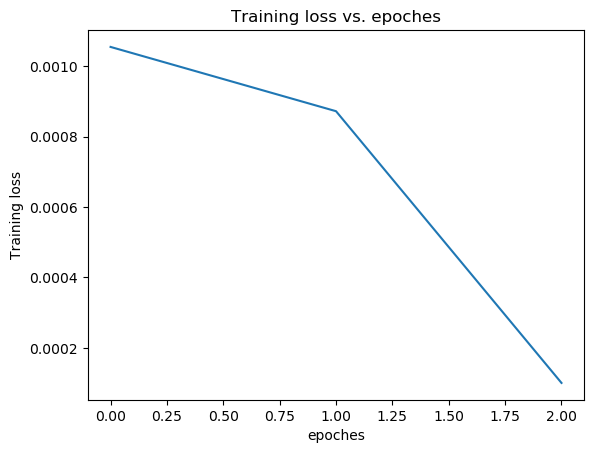

In [8]:
import matplotlib
import matplotlib.pyplot as plt

# training loss curve
iterition = range(num_epoches)
Loss = loss_list

plt.plot(iterition, Loss, '-')
plt.title('Training loss vs. epoches')
plt.ylabel('Training loss')
plt.xlabel('epoches')
# plt.savefig('./loss1.png')

## Save Model Trained

In [9]:
# save the model trained
# torch.save(model.state_dict(), 'checkpoint_resnet100.pth')

## Testing Results

In [10]:
# test

def test(split):
    model.eval()
    y_true = torch.Tensor([])
    y_score = torch.Tensor([])
    if torch.cuda.is_available(): # testing by using GPU if available
        y_true, y_score = y_true.cuda(), y_score.cuda()
        if split =='train':
            data_loader = train_loader_at_eval
        elif split =='test':
            data_loader = test_loader
        elif split =='val':
            data_loader = val_loader

        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs = inputs.cuda()
                targets = targets.cuda()
                outputs = model(inputs)
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

                y_true = torch.cat((y_true, targets), 0)
                y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        evaluator = Evaluator('pathmnist', split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        
    else:
        if split =='train':
            data_loader = train_loader_at_eval
        elif split =='test':
            data_loader = test_loader
        elif split =='val':
            data_loader = val_loader

        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs = inputs.cuda()
                targets = targets.cuda()
                outputs = model(inputs)
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

                y_true = torch.cat((y_true, targets), 0)
                y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator('pneumoniamnist', split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
train_result = test('train')
val_result = test('val')
test_result = test('test')

==> Evaluating ...
train  auc: 0.997  acc:0.937
val  auc: 0.997  acc:0.933
test  auc: 0.967  acc:0.843
